# Indian Buffet Processes

## Notes by Hugh Perkins, 2017

These notes adapted from:

- ["The Indian Buffet Process: An Introduction and Review"](http://jmlr.org/papers/volume12/griffiths11a/griffiths11a.pdf), Griffiths, Ghahramani, 2011
- ["Introduction to the Dirichlet Distribution and Related Processes"](http://mayagupta.org/publications/FrigyikKapilaGuptaIntroToDirichlet.pdf), Frigyik, Kapila, Gupta
- ["Advanced Data Analysis from an Elementary Point of View"](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/), Cosma Rohilla Shalizi, chapter 19, "Mixture Models"
- ["Mixture Models and the EM Algorithm"](http://mlg.eng.cam.ac.uk/tutorials/06/cb.pdf), slide presentation by Bishop 2006

The tutorial by Griffiths and Gahramani above was my primary resouce.  Then, in order to understand it, I needed to reach out to the other resources above :-)

Generally speaking, these notes assume that you are reading the appropriate tutorial/paper/slides in parallel with these notes.

These notes are organized approximately per-section:

- [ibp_section1](ibp_section1.ipynb) This pdf: revision of multinomial distributions, Dirichlet distributions, mixture models
- [ibp_section2](ibp_section2.ipynb)  Latent class models
- [ibp_section3](ibp_section3.ipynb)  Latent feature models

Let's start by revising multinomial and dirichlet distributions.

# Multinomial and Dirichlet Distributions

These notes adapted from "Introduction to the Dirichlet Distribution and Related Processes", Frigyik, Kapila, Gupta

## Multinomial distribution

The multinomial distribution is parametrized by an integer $n$ and a pmf $q = [q_1, q_2, \dots,q_k]$, and can be thought of as follows: if we have $n$ independent events, and for each event, the probability of outcome $i$ is $q_i$, then the multinomial distribution specifies the probability that outcome $i$ occurs $x_i$ times for $i=1,2,\dots,k$.  For example, the multinomial distribution can model the probability of an $n$-sample empirical histogram, if each sample is drawn iid from $q$.  If $X \sim \mathrm{Multinomial}_k(n,q)$, then its probability mass function is given by:

$$P(X=\{x_1,x_2,\dots,x_k \} \mid n,Q = \{q_1, q_2, ..., q_k\} ) = \frac{n!}{x_1!x_2!\dots x_k!}\prod_{i=1}^k q_i^{x_i}$$

When $k=2$, the multinomial distribution reduces to the binomial distribution.

Example with some actual concrete numbers plugged in:

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import math

n = 3
k = 3

# some possible distributions of x:
Xs = [
    [3, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
]

# and here's our Q, ie, in this case, uniform distribution of possible values:
Q = [1/k] * k

for X in Xs:
    numerator = math.factorial(n)
    denominator = 1
    prod_qi_xi = 1
    for i in range(k):
        denominator *= math.factorial(X[i])
        prod_qi_xi *= math.pow(Q[i], X[i])
    p = numerator * prod_qi_xi / denominator
    odds = 1 / p
    print('X', X, 'p', p, 'odds 1 in %s' % (int(odds * 10000) / 10000))


X [3, 0, 0] p 0.03703703703703703 odds 1 in 27.0
X [1, 1, 1] p 0.2222222222222222 odds 1 in 4.5
X [2, 1, 0] p 0.1111111111111111 odds 1 in 9.0


There are 3 ways of arranging `[3, 0, 0]`, 1 way of arranging `[1, 1, 1]`, and `3 * 2 = 6` ways of arranging `[2, 1, 0]`, so total probability is:

$$1/27 * 3 + 1/4.5 * 1 + 1/9 * 6$$

$$= 1$$ (As required)

## Dirichlet distribution

A Dirichlet distribution is a distribution over probability mass functions of length $k$, that is over the $k-1$-dimensional probability simplex $\Delta_k$, where:

$$\Delta_k = \left\{ q \in \mathbb{R}^k \mid \sum_{i=1}^k q_i = 1, q_i \ge 0 \ \, \mathrm{ for }\, i=1,2,\dots,k \right\}$$

If $q\sim \mathrm{Dir}(\alpha)$ then:

$$p(q \mid \alpha) = \frac{\Gamma(\alpha_0)}{\prod_{i=1}^k\Gamma(\alpha_i)}\prod_{i=1}^k q_i^{\alpha_i-1}$$

Gamma function is generalization of the factorial function: for $s \gt 0$:

$$\Gamma(s + 1) = s\Gamma(s)$$

For positive integers $n$, $\Gamma(n) = (n-1)!$, and $\Gamma(1) = 1$

When $k=2$, the Dirichlet reduces to the Beta distribution:

$$f(x;\alpha,\beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1}(1-x)^{\beta-1}$$

If $X \sim \mathrm{Beta}(a,b)$, then $Q=(X, 1-X) \sim \mathrm{Dir}(\alpha)$, where $\alpha=[a\,b]$

Note that the form of the Dirichlet Distribution is basically identical to the Multinomial Distribution, except:

- normalization is generalized, to handle non-integer $\alpha_i$ values, using Gamma function
- $1$ is subtracted from each $\alpha_i$ value

This will lead to the usage of a Dirichlet distribution as a conjugate prior for the Multinomial distribution, see later.

## Properties of the Dirichlet Distribution

(Just copying these from the tutorial mentioned above, without discussion for now)

Density: $\frac{1}{B(\alpha)} \prod_{j=1}^d q_j^{\alpha_j-1}$

Expectation: $\frac{\alpha_i}{\alpha_0}$

Mode: $\frac{\alpha - 1}{\alpha_0 - k}$

Marginal distribution: $q_i \sim \mathrm{Beta}(\alpha_i, \alpha_0 - \alpha_i)$

Conditional distribution: $(q_{-i} \mid q_i ) \sim (1 - q_i) \, \mathrm{Dir}(\alpha_{-i})$

## Conjugate prior for the multinomial

Let's draw as follows:

$$\mathbf{q} \sim \,\mathrm{Dir}\,(\mathbf{\alpha})$$
$$\mathbf{x} \sim \,\mathrm{Mult}_k\,(n, \mathbf{q}) $$

What is $p(\mathbf{q} \mid \mathbf{x}, \mathbf{\alpha})$?

$$p(\mathbf{q} \mid \mathbf{x} = \gamma \, p(\mathbf{x} \mid \mathbf{q})\,p(\mathbf{q})$$
$$=\gamma\, \mathrm{Mult}_k\,(n, \mathbf{q}) \, \mathrm{Dir}\,(\mathbf{\alpha})$$
$$=\gamma\left( \frac{n!}{x_1!x_2!\dots x_k!} \prod_{i=1}^k q_i^{x_i} \right) \left( \frac{\Gamma(\alpha_1 + \dots + \alpha_k}{\prod_{i=1}^k \Gamma(\alpha_i)} \prod_{i=1}^k q_i^{\alpha_i - 1} \right)$$
$$=\tilde{\gamma}\prod_{i=1}^k q_i^{\alpha_i + x_i - 1}$$
$$=\tilde{\gamma} \, \mathrm{Dir}(\mathbf{\alpha} + \mathbf{x})$$

Hence:
$$(Q \mid X = \mathbf{x}) \sim \mathrm{Dir}(\mathbf{\alpha} + \mathbf{x})$$

# Mixture models

Probably good to revise mixture models too...

These notes are based on [Cosma Shalizi's book](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/), chapter 19, "Mixture Models", and on the slide presentation ["Mixture Models and the EM Algorithm", Bishop 2006](http://mlg.eng.cam.ac.uk/tutorials/06/cb.pdf)

A mixture model is defined as:

$$p(\mathbf{x} = \sum_{i=1}^k \theta_i f_i(\mathbf{x})$$
where $f_i(\cdot)$ are probability distributions over $\mathbf{x}$, eg they could be Gaussian distributions.

To generate points, we need to:

- draw a class, $c_j$ for $j$ in $1,2,\dots n$
- draw a point, $\mathbf{x}_j$ for $j$ in $1,2,\dots,n$

Let's try this, for gaussian distributions, with $d=2$ features, and $k=3$ clusters:

theta [ 0.04313748  0.19931057  0.75755195]


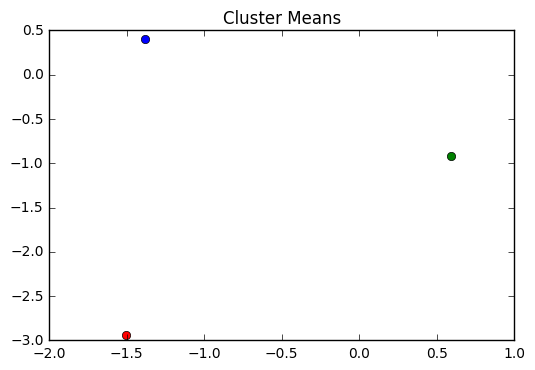

c_counts [ 10  70 220]


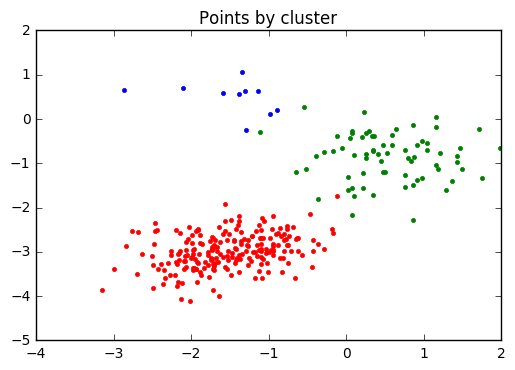

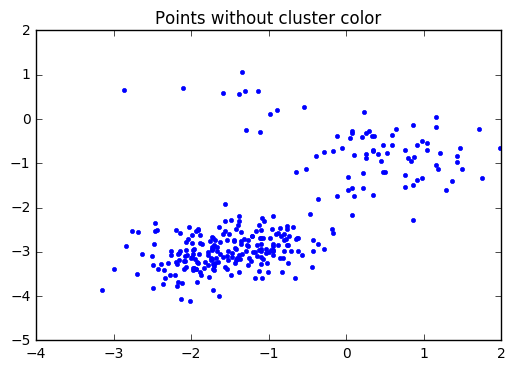

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

alpha = 1
D = 2
K = 3
N = 300

np.random.seed(122)

# draw theta, from uniform prior, using Dirichlet Distribution
# this uses the method from section 2.3 of the Frigyik, Kapila and Gupta tutorial earlier
gammas = np.random.gamma(alpha/K, 1, size=(K,))
# normalize to pdf
theta = gammas / np.sum(gammas)
print('theta', theta)

# draw gaussian means, for each cluster
gaussian_means = np.random.randn(K, 2)

# plot the means
for k in range(K):
    plt.plot(gaussian_means[k, 0], gaussian_means[k, 1], 'o')
plt.title('Cluster Means')
plt.show()

# draw gaussian covariance matrix, for each cluster
gaussian_covariances = np.random.randn(K, D, D)
# make positive semi-definite:
for k in range(K):
    gaussian_covariances[k] = gaussian_covariances[k].T.dot(gaussian_covariances[k])
# increase the diagonal a bit, so not too thin
for k in range(K):
    gaussian_covariances[k] += np.identity(D)
# shrink a bit, so dont dwarf the difference in means:
for k in range(K):
    gaussian_covariances[k] /= 8

# draw a distribution over classes:
c_counts = np.random.multinomial(N, theta)
print('c_counts', c_counts)

# draw points:
X = np.zeros((N, 2), dtype=np.float32)
n = 0
X_by_class = []
for c, count in enumerate(c_counts):
    samples = multivariate_normal.rvs(mean=gaussian_means[c], cov=gaussian_covariances[c], size=(count,))
    X[n: n+count] = samples
    X_by_class.append(samples)
    n += count

# plot by class:
for c in range(K):
    plt.plot(X_by_class[c][:, 0], X_by_class[c][:, 1], '.')
plt.title('Points by cluster')
plt.show()
    
# plot without class colors:
plt.plot(X[:, 0], X[:, 1], '.')
plt.title('Points without cluster color')
plt.show()

## Estimating parametric mixture models

(This bit is mostly from section 19.2 of [Cosma Shalizi's book](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/) )

Probability of observing our data given parameters is:

$$p(\mathbf{X} \mid \mathbf{\theta}) = \prod_{i=1}^n f(\mathbf{x}_i, \mathbf{\phi})$$

We can take `log`s, to turn multiplication into addition:

$$\log p(\mathbf{X} \mid \mathbf{\theta}) = \sum_{i=1}^n \log f(\mathbf{x}_i, \mathbf{\phi})$$

$$= \sum_{i=1}^n \log \sum_{j=1}^k \theta_k f(\mathbf{x}_i, \mathbf{\phi}_k)$$

Let's take derivative wrt some parameter, eg $\phi_l$.

The derivative of log function is:

$$ \frac{\partial \log(f(x))}{\partial x} = \frac{\partial f(x) / \partial x}{f(x)} $$

Meanwhile, all the terms in $f(x, \phi_k)$ where $k \ne l$ will vanish.

So:

$$\frac{ \partial\, p(\mathbf{X} \mid \mathbf{\theta}) }{\partial \, \phi_l} = \sum_{i=1}^n \frac{\theta_l \, \partial f(\mathbf{x}, \phi_l)}{\partial \phi_l}\frac{1}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)} $$
$$= \sum_{i=1}^n
\frac{\theta_l}{\sum_{j=1}^k\theta_j\, f(\mathbf{x}_i, \phi_j)}
\frac{f(\mathbf{x}_i, \phi_l)}{f(\mathbf{x}_i, \phi_l)}
\frac{\partial \, f(\mathbf{x}_i, \phi_l)}{\partial \phi_l}
$$

$$
= \sum_{i=1}^n
\frac{\theta_l \,f(\mathbf{x}_i, \phi_l)}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)}
\frac{\partial\,\log f(\mathbf{x}_i, \phi_l)}{\partial \, \phi_l}
$$

If we had an ordinary, non-mixture, parametric model, the joint probability would look like:

$$ p(\mathbf{X}, \phi) = \prod_{i=1}^n f(\mathbf{x}, \phi) $$
So:
$$\log p(\mathbf{X}, \phi)=\sum_{i=1}^n \log f(\mathbf{x}_i, \phi)$$

...and in this case there are no latent variables, $\theta$, and so the derivative wrt $\phi_l$ is:

$$\frac{\partial \, \log p(\mathbf{X}, \phi)}{\partial \, \phi_l}
= \sum_{i=1}^n \frac{\partial \log f(\mathbf{x}_i, \phi_l)}{\partial \, \phi_l}
$$

So, by comparison of the mixture-model case with the non-mixture case, the mixture-model case has the same form, but with weights:

$$w_{i,l} = \frac{\theta_l \, f(\mathbf{x}_i, \phi_l)}{\sum_{j=1}^k \theta_j \, f(\mathbf{x}_i, \phi_j)}$$

$$=\frac{p(Z=l, X=\mathbf{x}_i)}{p(X=\mathbf{x}_i)}$$
$$= p(Z=l \mid X=\mathbf{x}_i)$$

So, we will iterate:

- given an estimate of $Z$ assignments, estimate $\phi$
- given an estimate of $\phi$, estimate $Z$ assignments

Having looked at mixture models, let's look at [ibp_section2.ipynb](Latent class models)